# Valoración de opciones de compra europeas utilizando la fórmula Black-Scholes aplicada a acciones de Amazon

#### Por:
* Santiago Hincapie
* Sarah Henao
* Luisa Londoño

## Analisis cuantitativo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py # download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.offline as off
import plotly.graph_objs as go
import plotly.figure_factory as FF

#py.offline.init_notebook_mode(connected=True)

from scipy import stats
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
df = pd.read_csv('../data/NASDAQ:AMZN.csv')
df.Dates = df.Dates.map(lambda x: datetime.strptime(x, '%m/%d/%Y'))

In [3]:
py.iplot([go.Scatter(
            x=df.Dates,
            y=df.PX_LAST)])

In [4]:
py.iplot([go.Scatter(
           x=df.index,
           y=df.Returns)])

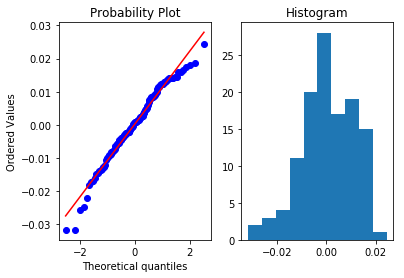

In [5]:
f, axarr = plt.subplots(1, 2)
axarr[1].hist(df.Returns)
axarr[1].set_title("Histogram")
stats.probplot(df.Returns, plot=axarr[0])
plt.rcParams["figure.figsize"] = (6, 3)
plt.savefig('plots/norm.png')

In [7]:
sh = stats.shapiro(df.Returns)
ks = stats.kstest(df.Returns, cdf='norm')
ad = stats.anderson(df.Returns)
da = stats.mstats.normaltest(df.Returns)

matrix_dp = [
    ['Test Name'             , 'Test Statistic', 'p-value'],
    ['Shapiro-Wilk'          , sh[0]           , sh[1]],
    ['Kolmogorov-Smirnov'    , ks[0]           , ks[1]],
    ['Anderson-Darling'      , ad[0]           , ad[1][2]],
    ['D’Agostino and Pearson', da[0]           , da[1]]
]

table = FF.create_table(matrix_dp, index=True)
py.iplot(table)

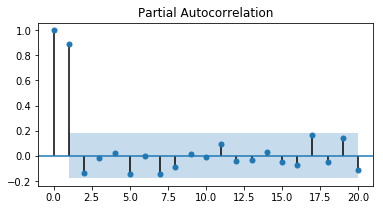

In [8]:
plot_pacf(df.PX_LAST, lags=20)
plt.show()

In [9]:
dt = 1/252 # Datos diarios
vsigma = np.sqrt(np.var(df.Returns)/dt)
print(vsigma)

S0 = df.PX_LAST.mean()
print(S0)

0.1726831558229783
982.3500833333334


## Diferencias finitas

In [10]:
%load_ext Cython

In [11]:
%%cython

cimport numpy as np
import numpy as np

def finite_difference(float r, float sigma, int K, int S_0,
                     int F_max, float dS, float T):
    """ Arbitrary Parameters
    r     : Tasa de interes libre de riesgo
    sigma : Volatilidad
    K     : Precio de ejercicio

    Initial Conditions
    S_0   : Valor de accion en tiempo actual
    S_max : Cota superior de la accion
    dS    : Tamaño de intervalos del precio
    M     : Intervalos del precio
    T     : Tiempo de muestreo
    N     : Intervalos del tiempo
    dT    : Tamaños de intervalos del tiempo
    """

    cdef int S_max = S_0 * F_max
    cdef Py_ssize_t M = int(S_max/dS)
    cdef float dT_tmp = (dS/(sigma*S_max))**2
    cdef Py_ssize_t N = int(np.ceil(T/dT_tmp))
    cdef float dT = T/N

    # Ponderación
    cdef np.ndarray[double] a, b, c, J
    a = np.zeros(M+1, dtype=np.float)
    b = np.zeros(M+1, dtype=np.float)
    c = np.zeros(M+1, dtype=np.float)
    J = np.arange(M+1, dtype=np.float)

    a = (dT/(1+r*dT)) * ((sigma**2 * J**2)/2 - (r * J/2))
    b = (dT/(1+r*dT)) * ((1/dT) - sigma**2 * J**2)
    c = (dT/(1+r*dT)) * ((sigma**2 * J**2)/2 + (r * J/2))

    cdef np.ndarray[double, ndim=2] F = np.zeros((N+1, M+1))
    
    # Condiciones de frontera
    F[:, 0] = max(-K, 0)
    F[N, :] = (J*dS - K).clip(min=0)
    F[:, M] = max(S_max - K, 0)

    # Llenar Malla
    cdef int i, j
    cdef bool 
    for i in range(N-1, -1, -1):
        for j in range(1, M):
            F[i, j] = a[j] * F[i+1, j-1] + b[j] * F[i+1, j] \
                      + c[j] * F[i+1, j+1]

    P = int(S_0/dS)
    FF = F[0, P]
    return F, FF, P

In [12]:
from scipy.stats import norm

def blsprice(r, v, K, S, T):
    # https://gist.github.com/carljohanrehn/4f20cc0433e10dc1c312
    d_1 = 1 / v / np.sqrt(T) * (np.log(S / K) + (r + v ** 2 / 2) * T)
    d_2 = d_1 - v * np.sqrt(T)
    return norm.cdf(d_1) * S - norm.cdf(d_2) * K * np.exp(-r * T)

#### parametros de prueba

In [13]:
r = 0.05
sigma = 0.7
K = 100
S_0 = 100
F = 2
dS = 5
dT = 1/12

In [14]:
BL = blsprice(r, sigma, K, S_0, dT)

In [ ]:
%%time
mesh_1, FF1, P1 = finite_difference(r, sigma, K, S_0, F, 1, dT)
mesh_05, FF05, P05 = finite_difference(r, sigma, K, S_0, F, 0.5, dT)
mesh_01, FF01, P01 = finite_difference(r, sigma, K, S_0, F, 0.1, dT)
mesh_005, FF005, P005 = finite_difference(r, sigma, K, S_0, F, 0.05, dT)


In [51]:
import gc
gc.collect()

851

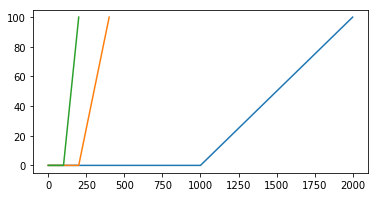

In [54]:
plt.plot(mesh_01[-1, :])
plt.plot(mesh_05[-1, :])
plt.plot(mesh_1[-1, :])
plt.show()